## Data Preprocessing

### Calculate the VAFs

Processing file 1/4: GLIO-12-g12b-somatic.XY.snvs.pass.vcf
  Found 1873 variants in g12b
Processing file 2/4: GLIO-12-g12c-somatic.XY.snvs.pass.vcf
  Found 1916 variants in g12c
Processing file 3/4: GLIO-12-g12e-somatic.XY.snvs.pass.vcf
  Found 1903 variants in g12e
Processing file 4/4: GLIO-12-g12f-somatic.XY.snvs.pass.vcf
  Found 2469 variants in g12f
Total variants across all samples: 8161
Sample of parsed variants:


,SAMPLE,CHROM,POS,REF,ALT,REF_COUNT,ALT_COUNT,TOTAL_COUNT,VAF,TUMOR_DEPTH,SOMATIC
0,g12b,chr1,642558,G,A,46,4,50,0.0800,50,True
1,g12b,chr1,656849,G,A,49,47,96,0.4896,96,True
2,g12b,chr1,785481,G,A,64,70,134,0.5224,134,True
3,g12b,chr1,1058211,G,A,72,60,132,0.4545,132,True
4,g12b,chr1,1072480,G,A,43,31,74,0.4189,74,True



Summary Statistics:
Total variants processed: 8161
Mean VAF: 0.3663
Median VAF: 0.3944
VAF range: 0.0099 - 1.0000

Sample summary:


,Variant Count,Mean VAF,Median VAF,Min VAF,Max VAF,Mean Depth,Median Depth
SAMPLE,,,,,,,
g12b,1873,0.4424,0.4511,0.0132,1.0,96.8564,73.0
g12c,1916,0.4294,0.4457,0.0133,1.0,116.9327,86.5
g12e,1903,0.3865,0.4000,0.0108,1.0,105.6863,80.0
g12f,2469,0.2439,0.2688,0.0099,1.0,114.6079,94.0



Chromosome distribution:


CHROM
chr1     766
chr19    667
chr2     586
chr17    572
chr16    446
chr3     395
chr6     386
chr9     384
chr12    383
chr11    379
chr7     343
chr5     337
chr10    330
chr14    327
chr15    306
chr4     305
chr8     295
chr22    232
chr20    205
chrX     173
chr13    159
chr18    117
chr21     58
chrY      10
Name: count, dtype: int64


VAF Range Distribution:


,Range,Count,Percentage
0,0.0-0.1,1455,17.8%
1,0.1-0.2,402,4.9%
2,0.2-0.3,662,8.1%
3,0.3-0.4,1662,20.4%
4,0.4-0.5,2349,28.8%
5,0.5-0.6,891,10.9%
6,0.6-1.0,667,8.2%



Generating visualizations...


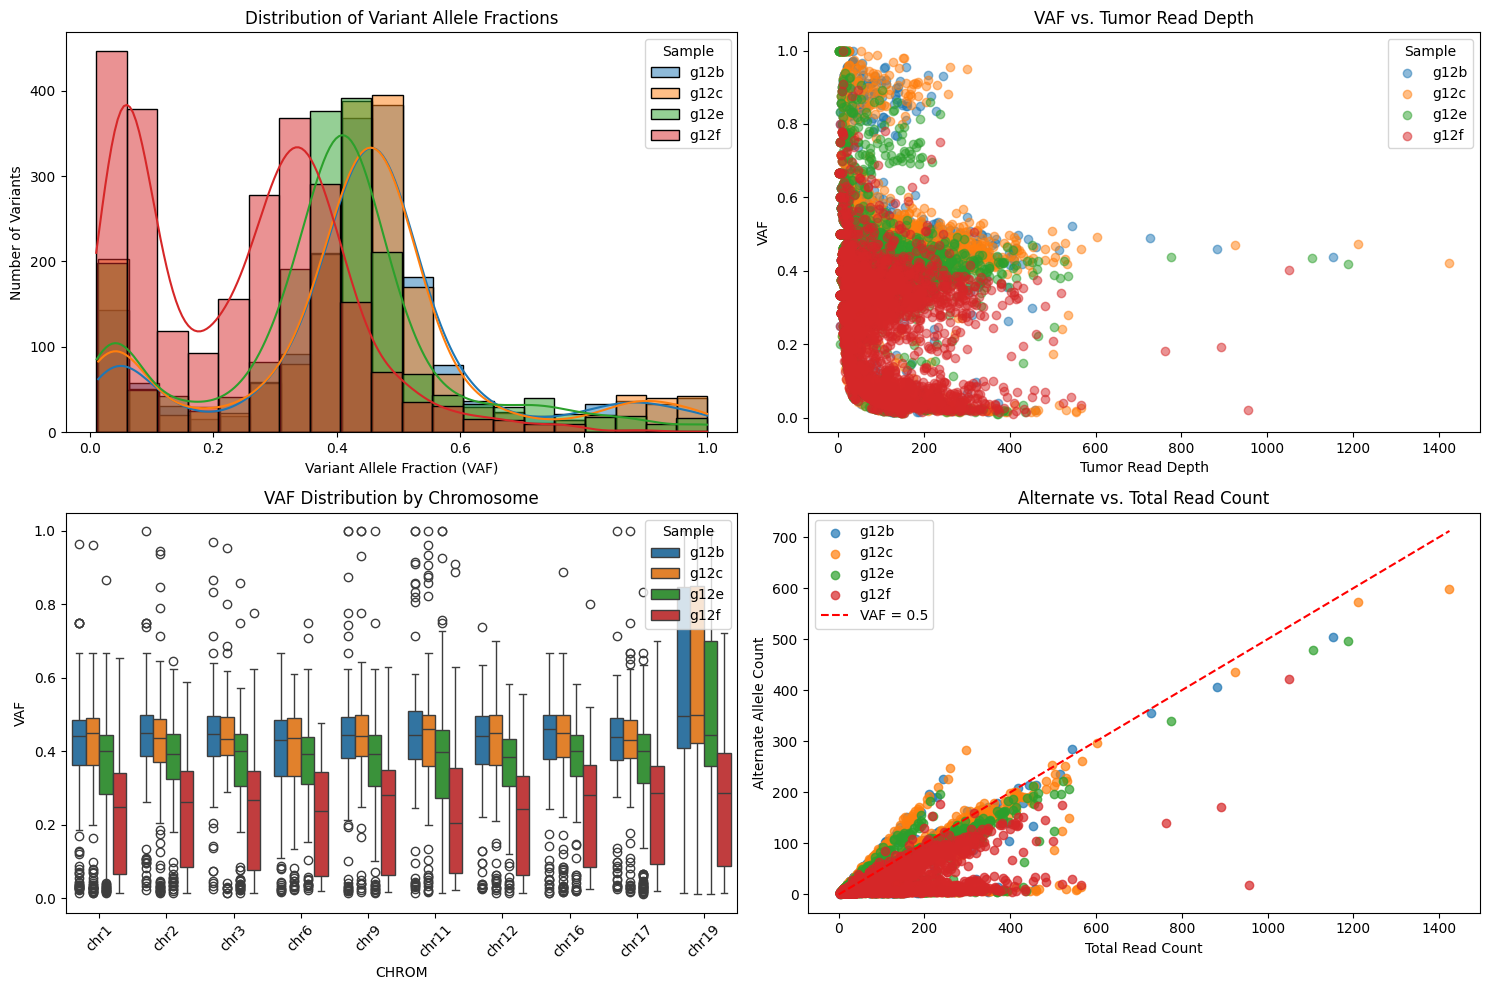

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_70031/3908434201.py:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None)


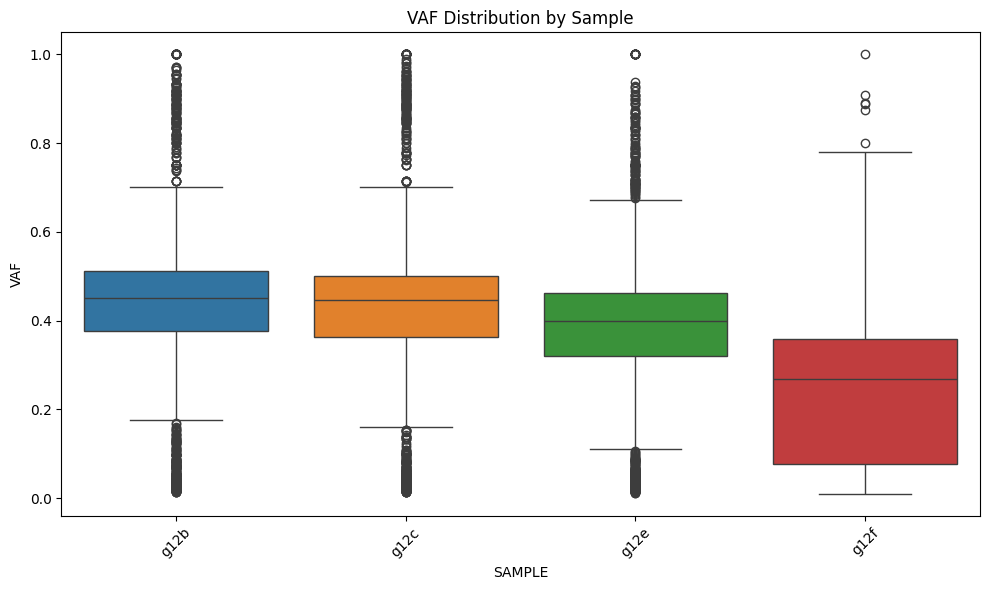

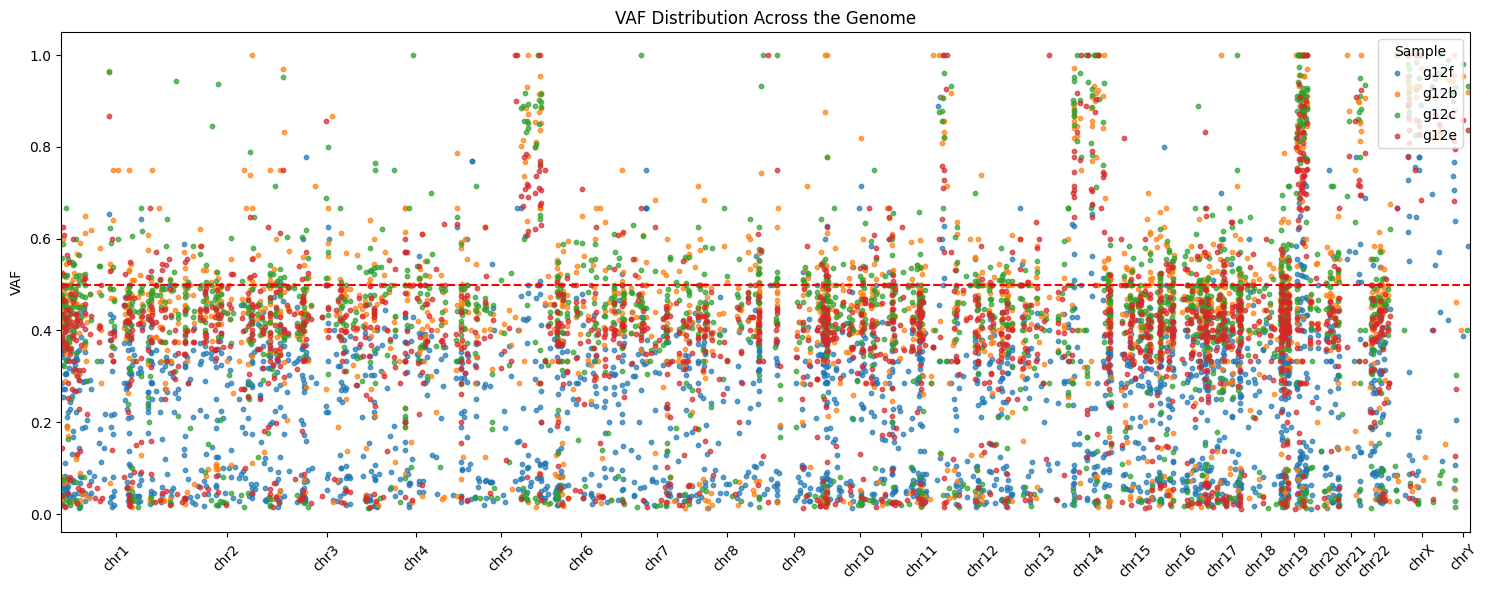


Comparing variants across samples:
Comparing variants across 4 samples:
Variants unique to a single sample: 2008 (55.2%)
Variants shared across exactly 2 samples: 111 (3.1%)
Variants shared across exactly 3 samples: 133 (3.7%)
Variants shared across all 4 samples: 1383 (38.0%)

Sample of shared variants VAF comparison:


SAMPLE,VARIANT_ID,g12b,g12c,g12e,g12f
0,chr10_100761136_G_A,0.2759,0.4878,0.6087,0.3889
1,chr10_100840699_G_A,0.4891,0.4694,0.3649,0.3272
2,chr10_103368964_G_A,0.4167,0.4583,0.3462,0.2857
3,chr10_103612617_T_C,0.5124,0.4797,0.5596,0.2941
4,chr10_104961542_A_G,0.4211,0.5556,0.5789,0.5000
5,chr10_107466333_G_A,0.4844,0.4161,0.3821,0.2857
6,chr10_113302297_T_C,0.4571,NaN,0.3478,NaN
7,chr10_11608944_G_A,0.5806,0.4727,0.4146,0.1628
8,chr10_117149488_C_A,NaN,NaN,0.1714,0.1633
9,chr10_117149489_A_C,NaN,NaN,0.2727,0.2581


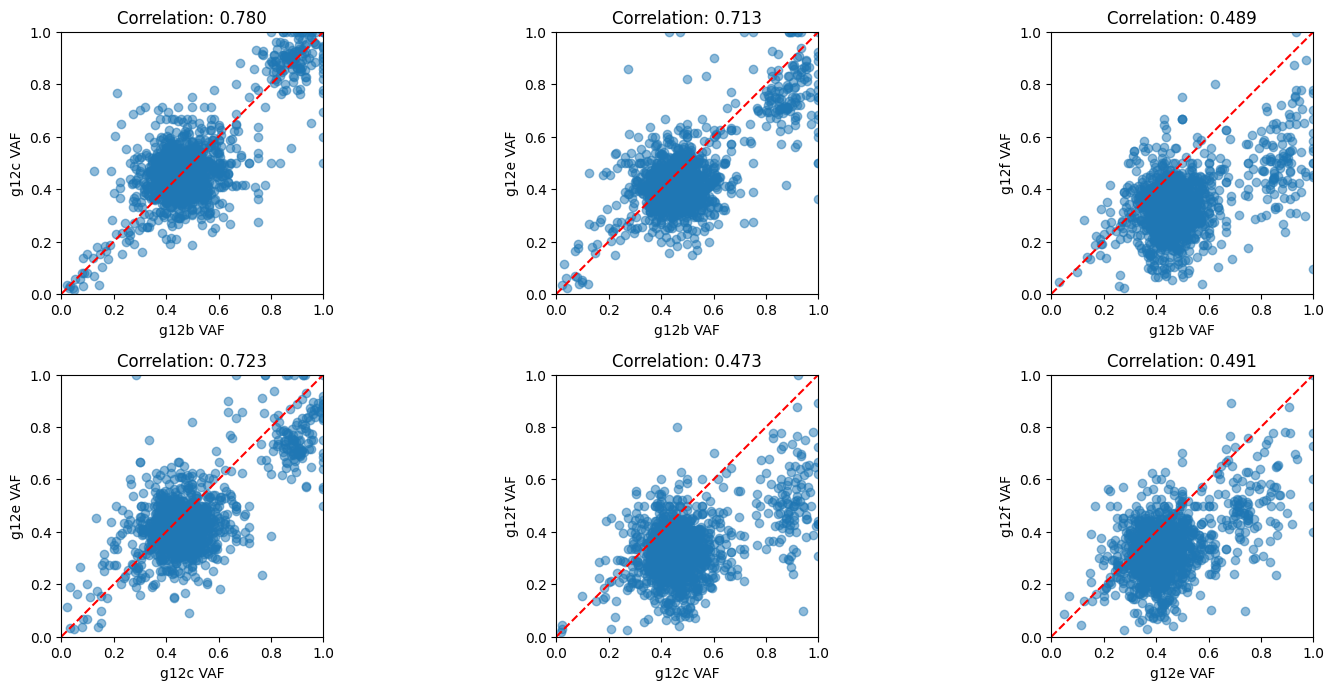

Data saved to ./strelka2_variants.tsv
Data saved to ./strelka2_variants.xlsx


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from IPython.display import display, HTML

def parse_strelka2_vcf(vcf_file, sample_name=None):
    """
    Parse Strelka2 VCF file and calculate Variant Allele Fractions (VAFs)
    
    Args:
        vcf_file (str): Path to the VCF file
        sample_name (str, optional): Sample name to include in the output
        
    Returns:
        pandas.DataFrame: DataFrame with variant information and VAFs
    """
    variants = []
    
    # Extract sample name from filename if not provided
    if sample_name is None:
        sample_name = os.path.basename(vcf_file).split('.')[2]
    
    with open(vcf_file, 'r') as f:
        for line in f:
            # Skip header lines
            if line.startswith('#'):
                continue
                
            # Parse variant line
            fields = line.strip().split('\t')
            
            if len(fields) < 10:  # Ensure we have all required fields
                continue
                
            chrom = fields[0]
            pos = int(fields[1])
            ref = fields[3]
            alt = fields[4]
            info = fields[7]
            format_fields = fields[8].split(':')
            normal_values = fields[9].split(':')
            tumor_values = fields[10].split(':')
            
            # Create a dictionary of format fields and their values
            normal_data = dict(zip(format_fields, normal_values))
            tumor_data = dict(zip(format_fields, tumor_values))
            
            # Extract reference and alternate counts according to the pseudocode
            # Strelka stores counts in AU, CU, GU, and TU fields
            # Map of nucleotides to their respective FORMAT field
            nucleotide_to_field = {
                'A': 'AU',
                'C': 'CU',
                'G': 'GU',
                'T': 'TU'
            }
            
            # Get the positions of these fields in the FORMAT column
            try:
                ref_counts_index = format_fields.index(nucleotide_to_field[ref])
                alt_counts_index = format_fields.index(nucleotide_to_field[alt])
            except (ValueError, KeyError):
                # Skip variants where the required fields are not present
                continue
                
            # Extract counts from the tumor sample
            tumor_ref_counts = tumor_values[ref_counts_index].split(',')
            tumor_alt_counts = tumor_values[alt_counts_index].split(',')
            
            # Extract tier1 counts (first value in comma-separated list)
            tier1_ref_counts = int(tumor_ref_counts[0])
            tier1_alt_counts = int(tumor_alt_counts[0])
            
            # Calculate VAF
            total_counts = tier1_ref_counts + tier1_alt_counts
            vaf = tier1_alt_counts / total_counts if total_counts > 0 else 0
            
            # Extract read depth from the DP field if available
            tumor_depth = int(tumor_data.get('DP', 0))
            
            # Extract somatic status from INFO field
            is_somatic = "SOMATIC" in info
            
            # Collect variant data
            variant_data = {
                'SAMPLE': sample_name,
                'CHROM': chrom,
                'POS': pos,
                'REF': ref,
                'ALT': alt,
                'REF_COUNT': tier1_ref_counts,
                'ALT_COUNT': tier1_alt_counts,
                'TOTAL_COUNT': total_counts,
                'VAF': round(vaf, 4),
                'TUMOR_DEPTH': tumor_depth,
                'SOMATIC': is_somatic
            }
            
            variants.append(variant_data)
    
    # Create a DataFrame from the collected variants
    variants_df = pd.DataFrame(variants)
    return variants_df

def extract_sample_name(filename):
    """
    Extract sample name from filename using the specified format:
    For "GLIO-12-g12b-somatic-sample.XY.snvs.pass.vcf", the sample name is "g12b"
    
    Args:
        filename (str): Full file path or filename
        
    Returns:
        str: Extracted sample name
    """
    # Get just the filename without path
    base_filename = os.path.basename(filename)
    
    # Split by hyphen and get the third element (index 2)
    try:
        parts = base_filename.split('-')
        if len(parts) > 2:
            return parts[2]  # Get the third element (index 2)
        else:
            # Fallback if the expected format isn't found
            return os.path.basename(filename).split('.')[0]
    except:
        # Fallback to the whole filename without extension
        return os.path.basename(filename).split('.')[0]

def process_multiple_vcfs(vcf_files, sample_names=None):
    """
    Process multiple VCF files and combine the results
    
    Args:
        vcf_files (list): List of VCF file paths
        sample_names (list, optional): List of sample names corresponding to VCF files
        
    Returns:
        pandas.DataFrame: Combined DataFrame with variant information and VAFs from all files
    """
    all_variants = []
    
    # If sample names not provided, extract from filenames
    if sample_names is None:
        sample_names = [extract_sample_name(f) for f in vcf_files]
    elif len(sample_names) != len(vcf_files):
        print("Warning: Number of sample names doesn't match number of files. Extracting from filenames instead.")
        sample_names = [extract_sample_name(f) for f in vcf_files]
    
    # Process each VCF file
    for i, vcf_file in enumerate(vcf_files):
        print(f"Processing file {i+1}/{len(vcf_files)}: {vcf_file}")
        try:
            variants_df = parse_strelka2_vcf(vcf_file, sample_names[i])
            all_variants.append(variants_df)
            print(f"  Found {len(variants_df)} variants in {sample_names[i]}")
        except Exception as e:
            print(f"  Error processing {vcf_file}: {e}")
    
    # Combine all dataframes
    if all_variants:
        combined_df = pd.concat(all_variants, ignore_index=True)
        print(f"Total variants across all samples: {len(combined_df)}")
        return combined_df
    else:
        print("No variants found in any file")
        return pd.DataFrame()

def display_summary_stats(data):
    """
    Display summary statistics for the VAF data
    
    Args:
        data (pandas.DataFrame): DataFrame with VAF data
    """
    # Overall stats
    print(f"Total variants processed: {len(data)}")
    print(f"Mean VAF: {data['VAF'].mean():.4f}")
    print(f"Median VAF: {data['VAF'].median():.4f}")
    print(f"VAF range: {data['VAF'].min():.4f} - {data['VAF'].max():.4f}")
    
    # Stats by sample if multiple samples
    if 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1:
        print("\nSample summary:")
        sample_summary = data.groupby('SAMPLE').agg({
            'VAF': ['count', 'mean', 'median', 'min', 'max'],
            'TUMOR_DEPTH': ['mean', 'median']
        })
        sample_summary.columns = ['Variant Count', 'Mean VAF', 'Median VAF', 'Min VAF', 'Max VAF', 
                               'Mean Depth', 'Median Depth']
        sample_summary = sample_summary.round(4)
        display(sample_summary)
    
    # Chromosome distribution
    print("\nChromosome distribution:")
    chrom_counts = data['CHROM'].value_counts()
    display(chrom_counts)
    
    # Count variants in VAF ranges
    vaf_ranges = [
        (0.0, 0.1),
        (0.1, 0.2),
        (0.2, 0.3),
        (0.3, 0.4),
        (0.4, 0.5),
        (0.5, 0.6),
        (0.6, 1.0)
    ]
    
    print("\nVAF Range Distribution:")
    vaf_range_data = []
    for vaf_min, vaf_max in vaf_ranges:
        count = ((data['VAF'] >= vaf_min) & (data['VAF'] < vaf_max)).sum()
        percent = (count / len(data)) * 100
        vaf_range_data.append({
            'Range': f"{vaf_min:.1f}-{vaf_max:.1f}",
            'Count': count,
            'Percentage': f"{percent:.1f}%"
        })
    
    display(pd.DataFrame(vaf_range_data))

def visualize_vafs(data, by_sample=True):
    """
    Create visualizations for the VAF data
    
    Args:
        data (pandas.DataFrame): DataFrame with VAF data
        by_sample (bool): Whether to color/group by sample
    """
    # Setup color palette for samples if we have multiple
    multiple_samples = 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1
    
    if multiple_samples and by_sample:
        samples = data['SAMPLE'].unique()
        # Create a categorical color palette
        palette = sns.color_palette("tab10", n_colors=len(samples))
        sample_colors = dict(zip(samples, palette))
    
    # Set up the plotting environment
    plt.figure(figsize=(15, 10))
    
    # 1. VAF Distribution Histogram
    plt.subplot(2, 2, 1)
    if multiple_samples and by_sample:
        for sample, color in sample_colors.items():
            sample_data = data[data['SAMPLE'] == sample]
            sns.histplot(sample_data['VAF'], bins=20, kde=True, 
                         label=sample, color=color, alpha=0.5)
        plt.legend(title='Sample')
    else:
        sns.histplot(data['VAF'], bins=20, kde=True)
    
    plt.xlabel('Variant Allele Fraction (VAF)')
    plt.ylabel('Number of Variants')
    plt.title('Distribution of Variant Allele Fractions')
    
    # 2. Scatter plot of VAF vs Read Depth
    plt.subplot(2, 2, 2)
    if multiple_samples and by_sample:
        for sample, color in sample_colors.items():
            sample_data = data[data['SAMPLE'] == sample]
            plt.scatter(sample_data['TUMOR_DEPTH'], sample_data['VAF'], 
                       alpha=0.5, color=color, label=sample)
        plt.legend(title='Sample')
    else:
        plt.scatter(data['TUMOR_DEPTH'], data['VAF'], alpha=0.5)
    
    plt.xlabel('Tumor Read Depth')
    plt.ylabel('VAF')
    plt.title('VAF vs. Tumor Read Depth')
    
    # 3. VAF by chromosome (boxplot)
    plt.subplot(2, 2, 3)
    
    # Select the top 10 chromosomes with most variants for clarity
    chrom_counts = data['CHROM'].value_counts()
    top_chroms = chrom_counts.index[:10].tolist()
    chrom_data = data[data['CHROM'].isin(top_chroms)]
    
    if multiple_samples and by_sample:
        sns.boxplot(x='CHROM', y='VAF', hue='SAMPLE', data=chrom_data, palette=sample_colors)
        plt.legend(title='Sample', loc='upper right')
    else:
        sns.boxplot(x='CHROM', y='VAF', data=chrom_data)
    
    plt.xticks(rotation=45)
    plt.title('VAF Distribution by Chromosome')
    
    # 4. Alt Count vs. Total Count scatter plot with VAF as color
    plt.subplot(2, 2, 4)
    
    if multiple_samples and by_sample:
        for sample, color in sample_colors.items():
            sample_data = data[data['SAMPLE'] == sample]
            plt.scatter(sample_data['TOTAL_COUNT'], sample_data['ALT_COUNT'], 
                       alpha=0.7, color=color, label=sample)
        plt.legend(title='Sample')
    else:
        scatter = plt.scatter(data['TOTAL_COUNT'], data['ALT_COUNT'], 
                             c=data['VAF'], cmap='viridis', 
                             alpha=0.7)
        plt.colorbar(scatter, label='VAF')
    
    # Add the VAF=0.5 line
    max_count = max(data['TOTAL_COUNT'])
    plt.plot([0, max_count], [0, max_count/2], 'r--', label='VAF = 0.5')
    
    plt.xlabel('Total Read Count')
    plt.ylabel('Alternate Allele Count')
    plt.title('Alternate vs. Total Read Count')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create sample-specific plots if we have multiple samples
    if multiple_samples:
        # VAF distribution by sample (boxplot)
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None)
        plt.xticks(rotation=45)
        plt.title('VAF Distribution by Sample')
        plt.tight_layout()
        plt.show()
    
    # Create genomic position plot (Manhattan-like plot)
    create_manhattan_plot(data, by_sample=by_sample)

def create_manhattan_plot(data, by_sample=True):
    """
    Create a Manhattan-like plot of VAFs across the genome
    
    Args:
        data (pandas.DataFrame): DataFrame with VAF data
        by_sample (bool): Whether to color by sample
    """
    multiple_samples = 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1
    
    plt.figure(figsize=(15, 6))
    
    # Sort data by chromosome and position
    data_copy = data.copy()
    data_copy['CHROM_CLEAN'] = data_copy['CHROM'].str.replace('chr', '')
    
    # Convert chromosome names to numeric values for sorting
    def chrom_to_num(chrom):
        if chrom in ['X', 'Y', 'M']:
            return {'X': 23, 'Y': 24, 'M': 25}[chrom]
        try:
            return int(chrom)
        except ValueError:
            return 999  # For any other non-numeric chromosomes
    
    data_copy['CHROM_NUM'] = data_copy['CHROM_CLEAN'].apply(chrom_to_num)
    data_copy = data_copy.sort_values(['CHROM_NUM', 'POS'])
    
    # Create a continuous x-axis for genomic position
    chromosomes = data_copy['CHROM'].unique()
    chrom_sizes = {}
    
    # Get the maximum position for each chromosome
    for chrom in chromosomes:
        chrom_data = data_copy[data_copy['CHROM'] == chrom]
        if not chrom_data.empty:
            chrom_sizes[chrom] = chrom_data['POS'].max()
    
    # Create accumulative positions
    chrom_pos = {}
    cum_pos = 0
    
    for chrom in sorted(chromosomes, key=lambda x: data_copy[data_copy['CHROM'] == x]['CHROM_NUM'].iloc[0]):
        chrom_pos[chrom] = cum_pos
        cum_pos += chrom_sizes.get(chrom, 0) + 5000000  # Add buffer between chromosomes
    
    # Add the accumulative position
    data_copy['GENOME_POS'] = data_copy.apply(lambda row: chrom_pos[row['CHROM']] + row['POS'], axis=1)
    
    # Different plotting strategy depending on samples
    if multiple_samples and by_sample:
        # Color by sample
        samples = data_copy['SAMPLE'].unique()
        palette = sns.color_palette("tab10", n_colors=len(samples))
        sample_colors = dict(zip(samples, palette))
        
        for sample, color in sample_colors.items():
            sample_data = data_copy[data_copy['SAMPLE'] == sample]
            plt.scatter(sample_data['GENOME_POS'], sample_data['VAF'], 
                      color=color, alpha=0.7, s=10, label=sample)
        
        plt.legend(title='Sample', loc='upper right')
    else:
        # Color by chromosome
        for i, chrom in enumerate(sorted(chromosomes, key=lambda x: data_copy[data_copy['CHROM'] == x]['CHROM_NUM'].iloc[0])):
            chrom_data = data_copy[data_copy['CHROM'] == chrom]
            if not chrom_data.empty:
                plt.scatter(chrom_data['GENOME_POS'], chrom_data['VAF'], 
                          color=f'C{i % 10}', alpha=0.7, s=10, label=chrom)
    
    # Add chromosome labels at the midpoint of each chromosome
    chrom_midpoints = {}
    for chrom in chromosomes:
        chrom_data = data_copy[data_copy['CHROM'] == chrom]
        if not chrom_data.empty:
            midpoint = chrom_pos[chrom] + chrom_sizes.get(chrom, 0) / 2
            chrom_midpoints[chrom] = midpoint
    
    plt.xticks([midpoint for midpoint in chrom_midpoints.values()], 
              [chrom for chrom in chrom_midpoints.keys()],
              rotation=45)
    
    plt.ylabel('VAF')
    plt.title('VAF Distribution Across the Genome')
    plt.axhline(y=0.5, color='r', linestyle='--', label='VAF = 0.5')
    
    # Handle legend - keep it manageable
    if not (multiple_samples and by_sample):
        handles, labels = plt.gca().get_legend_handles_labels()
        if len(handles) > 10:
            handles = handles[:10]
            labels = labels[:10]
            labels[-1] += "..."
        
        plt.legend(handles, labels, loc='upper right', title='Chromosomes')
    
    plt.xlim(0, cum_pos)
    plt.tight_layout()
    plt.show()

def compare_samples_shared_variants(data):
    """
    Compare variants shared between samples
    
    Args:
        data (pandas.DataFrame): DataFrame with variant data from multiple samples
    """
    if 'SAMPLE' not in data.columns or len(data['SAMPLE'].unique()) <= 1:
        print("This function requires data from multiple samples")
        return
    
    # Create a unique variant identifier
    data['VARIANT_ID'] = data['CHROM'] + '_' + data['POS'].astype(str) + '_' + data['REF'] + '_' + data['ALT']
    
    # Count occurrences of each variant
    variant_counts = data['VARIANT_ID'].value_counts().reset_index()
    variant_counts.columns = ['VARIANT_ID', 'SAMPLE_COUNT']
    
    # Merge back to get full variant info
    shared_data = pd.merge(data, variant_counts, on='VARIANT_ID')
    
    # Get list of samples
    samples = data['SAMPLE'].unique()
    num_samples = len(samples)
    
    # Print summary of shared variants
    print(f"Comparing variants across {num_samples} samples:")
    for i in range(1, num_samples + 1):
        count = (shared_data['SAMPLE_COUNT'] == i).sum() // i  # Divide by i because each variant appears i times
        percent = (count / len(variant_counts)) * 100
        if i == 1:
            print(f"Variants unique to a single sample: {count} ({percent:.1f}%)")
        elif i == num_samples:
            print(f"Variants shared across all {num_samples} samples: {count} ({percent:.1f}%)")
        else:
            print(f"Variants shared across exactly {i} samples: {count} ({percent:.1f}%)")
    
    # Create a pivot table of VAFs for shared variants
    if num_samples >= 2:
        # Get variants shared by at least 2 samples
        shared_variants = variant_counts[variant_counts['SAMPLE_COUNT'] >= 2]['VARIANT_ID'].tolist()
        
        if shared_variants:
            shared_data = data[data['VARIANT_ID'].isin(shared_variants)]
            
            # Pivot table for VAFs
            pivot_vaf = shared_data.pivot_table(
                index='VARIANT_ID', 
                columns='SAMPLE', 
                values='VAF', 
                aggfunc='mean'
            ).reset_index()
            
            # Show a sample of the pivot table
            print("\nSample of shared variants VAF comparison:")
            display(pivot_vaf.head(10))
            
            # Create scatter plots comparing VAFs between sample pairs
            if num_samples > 1:
                # Plot VAF correlations for each pair of samples
                plt.figure(figsize=(15, 10))
                plot_idx = 1
                
                for i in range(num_samples):
                    for j in range(i+1, num_samples):
                        sample1 = samples[i]
                        sample2 = samples[j]
                        
                        # Get VAFs for this sample pair
                        pair_data = pivot_vaf[[sample1, sample2]].dropna()
                        
                        if len(pair_data) > 0:
                            # Calculate correlation
                            corr = pair_data[sample1].corr(pair_data[sample2])
                            
                            # Plot
                            plt.subplot(num_samples-1, num_samples-1, plot_idx)
                            plt.scatter(pair_data[sample1], pair_data[sample2], alpha=0.5)
                            plt.plot([0, 1], [0, 1], 'r--')  # Identity line
                            plt.xlabel(f'{sample1} VAF')
                            plt.ylabel(f'{sample2} VAF')
                            plt.title(f'Correlation: {corr:.3f}')
                            plt.axis('square')
                            plt.xlim(0, 1)
                            plt.ylim(0, 1)
                        
                        plot_idx += 1
                
                plt.tight_layout()
                plt.show()
        else:
            print("No variants are shared between samples")

def save_results(data, output_dir='.', base_filename='strelka2_variants'):
    """
    Save the parsed data to various formats
    
    Args:
        data (pandas.DataFrame): DataFrame with variant data
        output_dir (str): Directory to save files
        base_filename (str): Base name for output files
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save to TSV
    tsv_path = os.path.join(output_dir, f"{base_filename}.tsv")
    data.to_csv(tsv_path, sep='\t', index=False)
    print(f"Data saved to {tsv_path}")
    
    # Save to Excel if more than one sample
    if 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1:
        excel_path = os.path.join(output_dir, f"{base_filename}.xlsx")
        
        # Create a writer
        with pd.ExcelWriter(excel_path) as writer:
            # Save all data to first sheet
            data.to_excel(writer, sheet_name='All Variants', index=False)
            
            # Save data for each sample to separate sheets
            for sample in data['SAMPLE'].unique():
                sample_data = data[data['SAMPLE'] == sample]
                sample_data.to_excel(writer, sheet_name=sample, index=False)
        
        print(f"Data saved to {excel_path}")

# Example usage in Jupyter notebook:
# 1. Define a list of VCF files to process
vcf_files = [
    "GLIO-12-g12b-somatic.XY.snvs.pass.vcf",
    "GLIO-12-g12c-somatic.XY.snvs.pass.vcf",
    "GLIO-12-g12e-somatic.XY.snvs.pass.vcf",
    "GLIO-12-g12f-somatic.XY.snvs.pass.vcf"
]

# 2. Process all VCF files with automatic sample name extraction
all_variants = process_multiple_vcfs(vcf_files)

# The sample name will be automatically extracted as "g12b" from the filename

# 3. Display sample of the data
print("Sample of parsed variants:")
display(all_variants.head())

# 4. Show summary statistics
print("\nSummary Statistics:")
display_summary_stats(all_variants)

# 5. Create visualizations
print("\nGenerating visualizations...")
visualize_vafs(all_variants, by_sample=True)

# 6. If you have multiple samples, compare shared variants
if 'SAMPLE' in all_variants.columns and len(all_variants['SAMPLE'].unique()) > 1:
    print("\nComparing variants across samples:")
    compare_samples_shared_variants(all_variants)

# 7. Save results to files
save_results(all_variants, output_dir='.', base_filename='strelka2_variants')

## PyClone-VI

### Convert the VAF data into the format expected by PyClone-VI

In [13]:
# Standalone VCF to PyClone-VI Converter
# This code assumes you've already parsed your VCF files using the previous code
# and have a DataFrame called 'all_variants' containing the VAF data

import pandas as pd
import os

def convert_to_pyclone_format(variants_df, output_dir="pyclone_input", 
                             default_tumor_content=0.5,
                             min_coverage=20, min_vaf=0.05):
    """
    Convert parsed VAF data to PyClone-VI input format
    
    Args:
        variants_df (pd.DataFrame): DataFrame with parsed variant data
        output_dir (str): Directory to save PyClone-VI input files
        default_tumor_content (float): Default tumor purity estimate (0-1)
        min_coverage (int): Minimum read coverage to include a variant
        min_vaf (float): Minimum VAF to include a variant
    
    Returns:
        dict: Dictionary of DataFrames with PyClone-VI formatted data for each sample
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter variants by coverage and VAF
    filtered_variants = variants_df[
        (variants_df['TOTAL_COUNT'] >= min_coverage) & 
        (variants_df['VAF'] >= min_vaf)
    ].copy()
    
    print(f"Filtered from {len(variants_df)} to {len(filtered_variants)} variants")
    print(f"  Minimum coverage: {min_coverage}")
    print(f"  Minimum VAF: {min_vaf}")
    
    # Create a dictionary to store results for each sample
    sample_results = {}
    
    # Process each sample separately if multiple samples exist
    if 'SAMPLE' in filtered_variants.columns:
        samples = filtered_variants['SAMPLE'].unique()
        print(f"Found {len(samples)} samples: {', '.join(samples)}")
        
        for sample in samples:
            sample_data = filtered_variants[filtered_variants['SAMPLE'] == sample]
            print(f"Processing {sample}: {len(sample_data)} variants")
            
            # Convert to PyClone format
            pyclone_data = []
            for _, row in sample_data.iterrows():
                # Create mutation_id from chromosome and position
                mutation_id = f"{row['CHROM']}:{row['POS']}:{row['REF']}>{row['ALT']}"
                
                # Set default copy number values (assuming diploid)
                normal_cn = 2  # Assuming autosomal
                major_cn = 2   # Default major copy number
                minor_cn = 1   # Default minor copy number
                
                # Adjust for sex chromosomes
                if row['CHROM'] in ['chrX', 'X', 'chrY', 'Y']:
                    if row['CHROM'] in ['chrX', 'X']:
                        # Set X chromosome values (assuming female)
                        pass  # Using defaults
                    elif row['CHROM'] in ['chrY', 'Y']:
                        # Set Y chromosome values (assuming male)
                        normal_cn = 1
                        major_cn = 1
                        minor_cn = 0
                
                # Add to PyClone data
                pyclone_data.append({
                    'mutation_id': mutation_id,
                    'sample_id': sample,
                    'ref_counts': row['REF_COUNT'],
                    'alt_counts': row['ALT_COUNT'],
                    'normal_cn': normal_cn,
                    'major_cn': major_cn,
                    'minor_cn': minor_cn,
                    'tumour_content': default_tumor_content
                })
            
            # Create PyClone DataFrame
            pyclone_df = pd.DataFrame(pyclone_data)
            
            # Save to file
            output_file = os.path.join(output_dir, f"{sample}_pyclone_input.tsv")
            pyclone_df.to_csv(output_file, sep='\t', index=False)
            print(f"  Saved to {output_file}")
            
            # Store in results dictionary
            sample_results[sample] = pyclone_df
        
        # Create a combined file for multi-sample analysis
        if len(samples) > 1:
            combined_file = os.path.join(output_dir, "combined_pyclone_input.tsv")
            combined_df = pd.concat(sample_results.values())
            combined_df.to_csv(combined_file, sep='\t', index=False)
            print(f"Combined file saved to {combined_file}")
    else:
        # Single sample without 'SAMPLE' column
        sample = "sample1"  # Default name
        print(f"Processing single sample: {len(filtered_variants)} variants")
        
        # Convert to PyClone format
        pyclone_data = []
        for _, row in filtered_variants.iterrows():
            # Create mutation_id from chromosome and position
            mutation_id = f"{row['CHROM']}:{row['POS']}:{row['REF']}>{row['ALT']}"
            
            # Set default copy number values (assuming diploid)
            normal_cn = 2  # Assuming autosomal
            major_cn = 2   # Default major copy number
            minor_cn = 1   # Default minor copy number
            
            # Adjust for sex chromosomes
            if row['CHROM'] in ['chrX', 'X', 'chrY', 'Y']:
                if row['CHROM'] in ['chrX', 'X']:
                    # Set X chromosome values (assuming female)
                    pass  # Using defaults
                elif row['CHROM'] in ['chrY', 'Y']:
                    # Set Y chromosome values (assuming male)
                    normal_cn = 1
                    major_cn = 1
                    minor_cn = 0
            
            # Add to PyClone data
            pyclone_data.append({
                'mutation_id': mutation_id,
                'sample_id': sample,
                'ref_counts': row['REF_COUNT'],
                'alt_counts': row['ALT_COUNT'],
                'normal_cn': normal_cn,
                'major_cn': major_cn,
                'minor_cn': minor_cn,
                'tumour_content': default_tumor_content
            })
        
        # Create PyClone DataFrame
        pyclone_df = pd.DataFrame(pyclone_data)
        
        # Save to file
        output_file = os.path.join(output_dir, "pyclone_input.tsv")
        pyclone_df.to_csv(output_file, sep='\t', index=False)
        print(f"Saved to {output_file}")
        
        # Store in results dictionary
        sample_results[sample] = pyclone_df
    
    return sample_results

# Example usage:
# Assuming 'all_variants' is the DataFrame from your previous VCF parsing step
# Run this to convert to PyClone-VI format:

# Set parameters
output_directory = "pyclone_input"  # Where to save PyClone input files
tumor_purity = 1                 # Estimated tumor purity (0-1)
min_read_coverage = 1              # Minimum total reads required
min_vaf_threshold = 0.00            # Minimum VAF required (5%)

# Convert to PyClone format
pyclone_data = convert_to_pyclone_format(
    all_variants,
    output_dir=output_directory,
    default_tumor_content=tumor_purity,
    min_coverage=min_read_coverage,
    min_vaf=min_vaf_threshold
)

# Display the first few rows of the first sample's PyClone input
first_sample = list(pyclone_data.keys())[0]
print(f"\nFirst few rows of PyClone input for {first_sample}:")
display(pyclone_data[first_sample].head())

Filtered from 8161 to 8161 variants
  Minimum coverage: 1
  Minimum VAF: 0.0
Found 4 samples: g12b, g12c, g12e, g12f
Processing g12b: 1873 variants
  Saved to pyclone_input/g12b_pyclone_input.tsv
Processing g12c: 1916 variants
  Saved to pyclone_input/g12c_pyclone_input.tsv
Processing g12e: 1903 variants
  Saved to pyclone_input/g12e_pyclone_input.tsv
Processing g12f: 2469 variants
  Saved to pyclone_input/g12f_pyclone_input.tsv
Combined file saved to pyclone_input/combined_pyclone_input.tsv

First few rows of PyClone input for g12b:


,mutation_id,sample_id,ref_counts,alt_counts,normal_cn,major_cn,minor_cn,tumour_content
0,chr1:642558:G>A,g12b,46,4,2,2,1,1
1,chr1:656849:G>A,g12b,49,47,2,2,1,1
2,chr1:785481:G>A,g12b,64,70,2,2,1,1
3,chr1:1058211:G>A,g12b,72,60,2,2,1,1
4,chr1:1072480:G>A,g12b,43,31,2,2,1,1


### Run the tool

In [18]:
!pyclone-vi fit -i pyclone_input/combined_pyclone_input.tsv -o pyclone_results.h5 -c 40 -d beta-binomial -r 10


Num Samples: 4
Samples: g12b g12c g12e g12f
Num mutations: 1383
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -715732.7366193555
Number of clusters used: 40

Fitting completed
ELBO: -24021.236262147206
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -896003.6821985524
Number of clusters used: 40

Fitting completed
ELBO: -23820.427273194982
Number of clusters used: 6

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -228805.01603431258
Number of clusters used: 40

Fitting completed
ELBO: -23838.031460800677
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -217658.32782506032
Number of clusters used: 40

Fitting completed
ELBO: -24047.00553764699
Number of clusters used: 3

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -532320.5901268439
Number of clusters used: 40

Fitting completed
ELBO: -23853.

In [19]:
!pyclone-vi write-results-file -i pyclone_results.h5 -o pyclone_results.tsv

/Users/nick/Library/Python/3.9/lib/python/site-packages/pyclone_vi/post_process.py:64: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


## CloneFinder

### Convert the VAF data into the format expected by CloneFinder

In [37]:
# VCF to CloneFinder Converter - Final Version
# This script converts the parsed VCF data to CloneFinder input format

import pandas as pd
import os

def convert_to_clonefinder_format(variants_df, output_file="clonefinder_input.txt", 
                                 min_coverage=20, min_vaf=0.05,
                                 snv_id_column=None, use_simple_ids=False,
                                 require_all_samples=False, 
                                 missing_ref_count=100):
    """
    Convert parsed VAF data to CloneFinder input format
    
    Args:
        variants_df (pd.DataFrame): DataFrame with parsed variant data
        output_file (str): Path to output file
        min_coverage (int): Minimum read coverage to include a variant
        min_vaf (float): Minimum VAF to include a variant
        snv_id_column (str, optional): Column to use as SNV ID, if None will create IDs
        use_simple_ids (bool): If True, generate simple SNV IDs (S1, S2, etc.)
        require_all_samples (bool): If True, only include variants found in all samples
        missing_ref_count (int): Reference count to use for variants not found in a sample
    
    Returns:
        pd.DataFrame: The CloneFinder formatted data
    """
    # Make a copy to avoid modifying the original
    variants_df = variants_df.copy()
    
    # Check if we have required columns
    required_cols = ['CHROM', 'POS', 'REF', 'ALT', 'REF_COUNT', 'ALT_COUNT']
    
    for col in required_cols:
        if col not in variants_df.columns:
            raise ValueError(f"Required column '{col}' not found in input data")
    
    # Check for SAMPLE column
    if 'SAMPLE' not in variants_df.columns:
        print("Warning: 'SAMPLE' column not found. Assuming all variants are from the same sample.")
        variants_df['SAMPLE'] = 'Sample1'
    
    # Filter variants by coverage and VAF
    total_count = variants_df['REF_COUNT'] + variants_df['ALT_COUNT']
    vaf = variants_df['ALT_COUNT'] / total_count.replace(0, 1)  # Avoid division by zero
    
    filtered_variants = variants_df[
        (total_count >= min_coverage) & 
        (vaf >= min_vaf)
    ].copy()
    
    print(f"Filtered from {len(variants_df)} to {len(filtered_variants)} variants")
    print(f"  Minimum coverage: {min_coverage}")
    print(f"  Minimum VAF: {min_vaf}")
    
    if len(filtered_variants) == 0:
        raise ValueError("No variants remain after filtering. Consider lowering thresholds.")
    
    # Get list of unique samples
    samples = sorted(filtered_variants['SAMPLE'].unique())
    print(f"Found {len(samples)} samples: {', '.join(samples)}")
    
    # Create mutation IDs
    if use_simple_ids:
        # Create simple sequential IDs (S1, S2, etc.)
        unique_variants = filtered_variants.drop_duplicates(['CHROM', 'POS', 'REF', 'ALT'])
        id_map = {
            (row['CHROM'], row['POS'], row['REF'], row['ALT']): f"S{i+1}" 
            for i, (_, row) in enumerate(unique_variants.iterrows())
        }
        filtered_variants['SNVID'] = filtered_variants.apply(
            lambda row: id_map[(row['CHROM'], row['POS'], row['REF'], row['ALT'])], axis=1
        )
        snv_id_column = 'SNVID'
    elif snv_id_column is None or snv_id_column not in filtered_variants.columns:
        print("Creating mutation IDs based on genomic coordinates")
        filtered_variants['SNVID'] = filtered_variants.apply(
            lambda row: f"{row['CHROM']}:{row['POS']}:{row['REF']}>{row['ALT']}", axis=1
        )
        snv_id_column = 'SNVID'
    
    # Find variants across samples based on setting
    if len(samples) > 1:
        variant_counts = filtered_variants.groupby(snv_id_column)['SAMPLE'].nunique()
        
        if require_all_samples:
            # Only keep variants present in all samples
            common_variants = variant_counts[variant_counts == len(samples)].index.tolist()
            
            if len(common_variants) == 0:
                print("Warning: No variants found in all samples. Consider setting require_all_samples=False")
                if len(variant_counts) > 0:
                    # Find variants in the maximum number of samples
                    max_samples = variant_counts.max()
                    common_variants = variant_counts[variant_counts == max_samples].index.tolist()
                    print(f"Including {len(common_variants)} variants found in {max_samples}/{len(samples)} samples")
            else:
                print(f"Found {len(common_variants)} variants present in all {len(samples)} samples")
        else:
            # Keep all variants
            common_variants = filtered_variants[snv_id_column].unique()
            print(f"Including all {len(common_variants)} variants (may not be present in all samples)")
            
        filtered_variants = filtered_variants[filtered_variants[snv_id_column].isin(common_variants)]
    
    # Create a reference for the alleles
    variant_alleles = {}
    for _, row in filtered_variants.iterrows():
        var_id = row[snv_id_column]
        if var_id not in variant_alleles:
            variant_alleles[var_id] = {
                'REF': row['REF'], 
                'ALT': row['ALT']
            }
    
    # Create a complete sample/variant matrix with appropriate values for missing variants
    all_variant_ids = filtered_variants[snv_id_column].unique()
    all_combinations = []
    
    for var_id in all_variant_ids:
        for sample in samples:
            sample_var_data = filtered_variants[
                (filtered_variants[snv_id_column] == var_id) & 
                (filtered_variants['SAMPLE'] == sample)
            ]
            
            if len(sample_var_data) > 0:
                # Variant exists in this sample
                ref_count = sample_var_data.iloc[0]['REF_COUNT']
                alt_count = sample_var_data.iloc[0]['ALT_COUNT']
            else:
                # Variant doesn't exist in this sample
                # Use placeholder value for reference count and 0 for alt count
                ref_count = missing_ref_count
                alt_count = 0
            
            all_combinations.append({
                snv_id_column: var_id,
                'SAMPLE': sample,
                'REF_COUNT': ref_count,
                'ALT_COUNT': alt_count
            })
    
    # Create a new DataFrame with all combinations
    complete_variants = pd.DataFrame(all_combinations)
    
    # Create pivot tables for the reference and alternate counts
    pivot_ref = complete_variants.pivot_table(
        index=snv_id_column, 
        columns='SAMPLE', 
        values='REF_COUNT', 
        aggfunc='first'
    ).reset_index()
    
    pivot_alt = complete_variants.pivot_table(
        index=snv_id_column, 
        columns='SAMPLE', 
        values='ALT_COUNT', 
        aggfunc='first'
    )
    
    # Rename columns to match CloneFinder format
    pivot_ref.columns.name = None
    for sample in samples:
        pivot_ref.rename(columns={sample: f"{sample}:ref"}, inplace=True)
    
    pivot_alt.columns.name = None
    for sample in samples:
        pivot_alt.rename(columns={sample: f"{sample}:alt"}, inplace=True)
    
    # Merge the pivot tables
    clonefinder_data = pivot_ref.copy()
    
    # Add Wild and Mut columns (reference and alternate alleles)
    clonefinder_data['Wild'] = clonefinder_data[snv_id_column].map(
        {var_id: alleles['REF'] for var_id, alleles in variant_alleles.items()}
    )
    clonefinder_data['Mut'] = clonefinder_data[snv_id_column].map(
        {var_id: alleles['ALT'] for var_id, alleles in variant_alleles.items()}
    )
    
    # Reorder columns to match expected format
    cols = [snv_id_column, 'Wild', 'Mut']
    
    # Add reference count columns
    for sample in samples:
        cols.append(f"{sample}:ref")
    
    # Add alternate count columns
    for sample in samples:
        cols.append(f"{sample}:alt")
        clonefinder_data[f"{sample}:alt"] = pivot_alt[f"{sample}:alt"].values
    
    # Select and order columns
    clonefinder_data = clonefinder_data[cols]
    
    # Save to file
    clonefinder_data.to_csv(output_file, sep='\t', index=False)
    print(f"CloneFinder input saved to {output_file}")
    
    return clonefinder_data

# Example usage:
# Assuming all_variants is the DataFrame from your previous VCF parsing step

# Set parameters
output_file = "clonefinder_input.txt"    # Output file path
min_read_coverage = 1                    # Minimum total reads required
min_vaf_threshold = 0.00                 # Minimum VAF required (5%)
missing_ref_value = 100                   # Reference count for variants not detected in a sample

# Convert to CloneFinder format with the following command:
clonefinder_data = convert_to_clonefinder_format(
    all_variants,
    output_file=output_file,
    min_coverage=min_read_coverage,
    min_vaf=min_vaf_threshold,
    use_simple_ids=True,                # Use simple S1, S2, etc. IDs
    missing_ref_count=missing_ref_value # Reference count placeholder for missing variants
)

# Display the first few rows
# display(clonefinder_data.head())

Filtered from 8161 to 8161 variants
  Minimum coverage: 1
  Minimum VAF: 0.0
Found 4 samples: g12b, g12c, g12e, g12f
Including all 3635 variants (may not be present in all samples)
CloneFinder input saved to clonefinder_input.txt


### Run the tool

In [38]:
!cd CloneFinder/ && python3 clonefinder.py snv ../clonefinder_input.txt

2025-03-09 11:44:21.032306
loading config file: options.ini
config parameters loaded successfully
parsing command-line parameters...
parsing input data file...
parsing header...
initializing...
initialized
header parsed
building profile list...
profile list is built
parsing completed
parsing CNV data file...
parsing header...
header parsed
add initial ancestor
constructing MP tree
executing megacc parsimony tree construction in /var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/
MEGA-CC 11.0.13 Molecular Evolutionary Genetics Analysis
Build#: 11220620-x86_64
9-3-25 11:44:21

Data file                                         : mega_alignment.meg
Status                                            : Reading header
Current Progress                                  : 1% 
Status                                            : Organizing sequence information                                           

No. of Taxa                                       : 5
Using the following analysis options:
No. of

## LICHeE

### Convert the VAF data into the format expected by LICHeE

In [ ]:
# VCF to LICHeE Converter
# This script converts the parsed VCF data to LICHeE input format

import pandas as pd
import os

def convert_to_lichee_format(variants_df, output_file="lichee_input.txt", 
                            min_coverage=20, min_vaf=0.05,
                            normal_sample=None, normal_vaf=0.0,
                            gene_column=None):
    """
    Convert parsed VAF data to LICHeE input format
    
    Args:
        variants_df (pd.DataFrame): DataFrame with parsed variant data
        output_file (str): Path to output file
        min_coverage (int): Minimum read coverage to include a variant
        min_vaf (float): Minimum VAF to include a variant
        normal_sample (str, optional): Name of normal sample if included in data
        normal_vaf (float): VAF value to use for normal sample if not in data
        gene_column (str, optional): Column name containing gene names
    
    Returns:
        pd.DataFrame: The LICHeE formatted data
    """
    # Make a copy to avoid modifying the original
    variants_df = variants_df.copy()
    
    # Check if we have required columns
    required_cols = ['CHROM', 'POS', 'REF', 'ALT', 'REF_COUNT', 'ALT_COUNT', 'VAF']
    
    for col in required_cols:
        if col not in variants_df.columns:
            if col == 'VAF':
                # Calculate VAF if not provided
                print("Calculating VAF from REF_COUNT and ALT_COUNT")
                total_count = variants_df['REF_COUNT'] + variants_df['ALT_COUNT']
                variants_df['VAF'] = variants_df['ALT_COUNT'] / total_count.replace(0, 1)  # Avoid division by zero
            else:
                raise ValueError(f"Required column '{col}' not found in input data")
    
    # Check for SAMPLE column
    if 'SAMPLE' not in variants_df.columns:
        print("Warning: 'SAMPLE' column not found. Assuming all variants are from the same sample.")
        variants_df['SAMPLE'] = 'Sample1'
    
    # Filter variants by coverage and VAF
    total_count = variants_df['REF_COUNT'] + variants_df['ALT_COUNT']
    
    filtered_variants = variants_df[
        (total_count >= min_coverage) & 
        (variants_df['VAF'] >= min_vaf)
    ].copy()
    
    print(f"Filtered from {len(variants_df)} to {len(filtered_variants)} variants")
    print(f"Minimum coverage: {min_coverage}")
    print(f"Minimum VAF: {min_vaf}")
    
    if len(filtered_variants) == 0:
        raise ValueError("No variants remain after filtering. Consider lowering thresholds.")
    
    # Get list of unique samples
    samples = sorted(filtered_variants['SAMPLE'].unique())
    
    # Remove normal sample from tumor sample list if specified
    if normal_sample and normal_sample in samples:
        samples.remove(normal_sample)
        print(f"Found normal sample: {normal_sample}")
    
    print(f"Found {len(samples)} tumor samples: {', '.join(samples)}")
    
    # Create a description column
    if gene_column and gene_column in filtered_variants.columns:
        # Use gene name if available
        filtered_variants['description'] = filtered_variants.apply(
            lambda row: f"{row['REF']}/{row['ALT']} {row[gene_column]}", axis=1
        )
    else:
        # Just use the allele change
        filtered_variants['description'] = filtered_variants.apply(
            lambda row: f"{row['REF']}/{row['ALT']}", axis=1
        )
    
    # Convert chromosome format if needed (ensure "chr" prefix is removed)
    filtered_variants['clean_chrom'] = filtered_variants['CHROM'].str.replace('chr', '')
    
    # Create a unique variant ID from chromosome and position
    filtered_variants['var_id'] = filtered_variants.apply(
        lambda row: f"{row['clean_chrom']}_{row['POS']}_{row['REF']}_{row['ALT']}", axis=1
    )
    
    # Extract unique variants (same chr, pos, ref, alt may appear in multiple samples)
    unique_variants = filtered_variants.drop_duplicates('var_id')
    
    # Create a pivot table with VAFs for each sample
    pivot_vaf = filtered_variants.pivot_table(
        index='var_id', 
        columns='SAMPLE', 
        values='VAF', 
        aggfunc='mean'  # Use mean in case of duplicates
    ).fillna(0)  # Fill missing values with 0 (variant not found in that sample)
    
    # Get chromosome, position, and description for each variant
    var_info = unique_variants.set_index('var_id')[['clean_chrom', 'POS', 'description']]
    
    # Merge VAFs with variant info
    lichee_data = var_info.join(pivot_vaf).reset_index()
    
    # Create output DataFrame in LICHeE format
    output_columns = ['clean_chrom', 'POS', 'description']
    
    # Add normal sample column if needed
    if normal_sample and normal_sample in pivot_vaf.columns:
        # Normal sample exists in the data
        output_columns.append(normal_sample)
    else:
        # Add a placeholder normal sample with VAF 0.0
        lichee_data['Normal'] = normal_vaf
        output_columns.append('Normal')
    
    # Add tumor sample columns
    output_columns.extend(samples)
    
    # Select and rename columns
    lichee_data = lichee_data[output_columns]
    lichee_data.columns = ['#chr', 'position', 'description'] + ([normal_sample] if normal_sample in pivot_vaf.columns else ['Normal']) + samples
    
    # Convert numeric values to appropriate format
    lichee_data['position'] = lichee_data['position'].astype(int)
    for sample in samples + (['Normal'] if 'Normal' in lichee_data.columns else [normal_sample]):
        lichee_data[sample] = lichee_data[sample].round(2)
    
    # Save to file
    lichee_data.to_csv(output_file, sep='\t', index=False, float_format='%.2f')
    print(f"LICHeE input saved to {output_file}")
    
    return lichee_data

# Example usage:
# Assuming all_variants is the DataFrame from your previous VCF parsing step

# Set parameters
output_file = "lichee_input.txt"      # Output file path
min_read_coverage = 150                 # Minimum total reads required
min_vaf_threshold = 0.00             # Minimum VAF required (5%)

# Convert to LICHeE format with the following command:
lichee_data = convert_to_lichee_format(
    all_variants,
    output_file=output_file,
    min_coverage=min_read_coverage,
    min_vaf=min_vaf_threshold,
    normal_sample=None,              # Specify normal sample name if in your data
    normal_vaf=0.0,                  # VAF to use for normal sample (usually 0.0)
    gene_column=None                 # Column with gene names (if available)
)

# Display the first few rows
# display(lichee_data.head())

Filtered from 8161 to 2089 variants
  Minimum coverage: 150
  Minimum VAF: 0.0
Found 4 tumor samples: g12b, g12c, g12e, g12f
LICHeE input saved to lichee_input.txt


### Run the tool

./lichee -build -i ../../../lichee_input.txt -maxVAFAbsent 0.005 -minVAFPresent 0.005 -n 0 -showTree 1 -s 1 -v

run the following from the lichee release folder

need to leave off the -showTree 1 -s 1 for the file to generate

i also had to use a high min read coverage threshold (150)

./lichee -build -i ../../../lichee_input.txt -maxVAFAbsent 0.005 -minVAFPresent 0.005 -n 0 -minClusterSize 20 -minPrivateClusterSize 20

i also had to rebuild the release jar according to the suggestions in this post https://github.com/viq854/lichee/issues/14



## Compare results

### Code to generate the comparisons

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
import os

class ClonalComparisonTool:
    def __init__(self, pyclone_file=None, clonefinder_file=None, lichee_file=None):
        """
        Initialize the comparison tool with paths to output files from clonal deconvolution tools.
        
        Args:
            pyclone_file (str): Path to PyClone-VI output file
            clonefinder_file (str): Path to CloneFinder output file
            lichee_file (str): Path to LICHeE output file
        """
        self.pyclone_file = pyclone_file
        self.clonefinder_file = clonefinder_file
        self.lichee_file = lichee_file
        
        # Data structures to store parsed results
        self.pyclone_data = None
        self.clonefinder_data = None
        self.lichee_data = {
            'nodes': {},
            'tree': [],
            'sample_decomposition': {},
            'snv_info': {}
        }
        
        # Standardized data for comparison
        self.samples = []
        self.mutations = {}
        self.clones = {
            'pyclone': {},
            'clonefinder': {},
            'lichee': {}
        }
        
        # Parse data if files are provided
        if pyclone_file:
            self.parse_pyclone()
        if clonefinder_file:
            self.parse_clonefinder()
        if lichee_file:
            self.parse_lichee()
            
        # Identify common samples across tools
        self._identify_common_samples()
        
    def parse_pyclone(self):
        """Parse PyClone-VI output file."""
        print(f"Parsing PyClone-VI file: {self.pyclone_file}")
        try:
            self.pyclone_data = pd.read_csv(self.pyclone_file, sep='\t')
            print(f"  Found {len(self.pyclone_data['mutation_id'].unique())} mutations")
            print(f"  Found {len(self.pyclone_data['sample_id'].unique())} samples")
            print(f"  Found {len(self.pyclone_data['cluster_id'].unique())} clusters")
            
            # Convert data to standardized format
            # Group by cluster_id and sample_id to get cellular_prevalence for each cluster in each sample
            clones_by_sample = {}
            for sample in self.pyclone_data['sample_id'].unique():
                sample_data = self.pyclone_data[self.pyclone_data['sample_id'] == sample]
                clones_in_sample = {}
                
                for cluster in sample_data['cluster_id'].unique():
                    cluster_data = sample_data[sample_data['cluster_id'] == cluster]
                    # Take the first row's prevalence for the cluster
                    prevalence = float(cluster_data['cellular_prevalence'].iloc[0])
                    clones_in_sample[f"cluster_{cluster}"] = prevalence
                
                clones_by_sample[sample] = clones_in_sample
            
            self.clones['pyclone'] = clones_by_sample
            
            # Store mutation assignments
            for _, row in self.pyclone_data.iterrows():
                mutation_id = row['mutation_id']
                sample_id = row['sample_id']
                cluster_id = f"cluster_{row['cluster_id']}"
                prevalence = float(row['cellular_prevalence'])
                
                if mutation_id not in self.mutations:
                    self.mutations[mutation_id] = {
                        'assignments': {},
                        'prevalence': {}
                    }
                
                if sample_id not in self.mutations[mutation_id]['assignments']:
                    self.mutations[mutation_id]['assignments'][sample_id] = {}
                    self.mutations[mutation_id]['prevalence'][sample_id] = {}
                
                self.mutations[mutation_id]['assignments'][sample_id]['pyclone'] = cluster_id
                self.mutations[mutation_id]['prevalence'][sample_id]['pyclone'] = prevalence
            
        except Exception as e:
            print(f"Error parsing PyClone-VI file: {e}")
    
    def parse_clonefinder(self):
        """Parse CloneFinder output file."""
        print(f"Parsing CloneFinder file: {self.clonefinder_file}")
        try:
            self.clonefinder_data = pd.read_csv(self.clonefinder_file, sep='\t')
            print(f"  Found {len(self.clonefinder_data)} samples")
            print(f"  Found {len(self.clonefinder_data.columns) - 1} clones")
            
            # Convert to standardized format
            clones_by_sample = {}
            for _, row in self.clonefinder_data.iterrows():
                sample = row['Tumor']
                clones_in_sample = {}
                
                for col in self.clonefinder_data.columns:
                    if col != 'Tumor':
                        # Only include clones with non-zero frequency
                        if float(row[col]) > 0:
                            clones_in_sample[col] = float(row[col])
                
                clones_by_sample[sample] = clones_in_sample
            
            self.clones['clonefinder'] = clones_by_sample
            
        except Exception as e:
            print(f"Error parsing CloneFinder file: {e}")
    
    def parse_lichee(self):
        """Parse LICHeE output file."""
        print(f"Parsing LICHeE file: {self.lichee_file}")
        try:
            with open(self.lichee_file, 'r') as f:
                content = f.read()
            
            # Parse Nodes section
            nodes_section = re.search(r'Nodes:(.*?)(?=\*\*\*\*Tree)', content, re.DOTALL)
            if nodes_section:
                nodes_text = nodes_section.group(1).strip()
                for line in nodes_text.split('\n'):
                    if line.strip():
                        parts = line.split('\t')
                        if len(parts) >= 4:  # Node ID, binary profile, frequencies, mutations...
                            node_id = parts[0]
                            binary_profile = parts[1]
                            
                            # Extract frequencies from the format like [ 0.45 0.45 0.41 0.32]
                            frequencies_str = parts[2].strip('[]')
                            frequencies = [float(f) for f in frequencies_str.split() if f]
                            
                            # Extract mutations
                            mutations = parts[3:]
                            
                            self.lichee_data['nodes'][node_id] = {
                                'binary_profile': binary_profile,
                                'frequencies': frequencies,
                                'mutations': mutations
                            }
                
                print(f"  Found {len(self.lichee_data['nodes'])} nodes")
            
            # Parse Tree section
            tree_section = re.search(r'\*\*\*\*Tree.*?\*\*\*\*(.*?)(?=Sample decomposition:)', content, re.DOTALL)
            if tree_section:
                tree_text = tree_section.group(1).strip()
                for line in tree_text.split('\n'):
                    if '->' in line:
                        parent, child = line.split('->')
                        self.lichee_data['tree'].append((parent.strip(), child.strip()))
            
            # Parse Sample decomposition section
            sample_section = re.search(r'Sample decomposition:(.*?)(?=SNV info:)', content, re.DOTALL)
            if sample_section:
                sample_text = sample_section.group(1)
                current_sample = None
                sample_data = {}
                
                for line in sample_text.split('\n'):
                    if 'Sample lineage decomposition:' in line:
                        current_sample = line.split(':')[1].strip()
                        sample_data[current_sample] = []
                    elif current_sample and line.strip() and not line.startswith('\t'):
                        # This assumes lineage data format with dots and prevalence
                        # Example: ".....01111: 0.452 [0.042]"
                        sample_data[current_sample].append(line.strip())
                
                self.lichee_data['sample_decomposition'] = sample_data
                
                # Extract samples
                samples = [s for s in sample_data.keys() if s != 'Normal']
                print(f"  Found {len(samples)} samples: {', '.join(samples)}")
            
            # Parse SNV info section
            snv_section = re.search(r'SNV info:(.*)', content, re.DOTALL)
            if snv_section:
                snv_text = snv_section.group(1).strip()
                for line in snv_text.split('\n'):
                    if line.strip() and ': ' in line:
                        snv_id, snv_info = line.split(': ', 1)
                        self.lichee_data['snv_info'][snv_id] = snv_info
                
                print(f"  Found {len(self.lichee_data['snv_info'])} SNVs with info")
            
            # Convert to standardized format
            # Map LICHeE nodes to samples and frequencies
            sample_frequencies = {}
            for sample, lineages in self.lichee_data['sample_decomposition'].items():
                if sample != 'Normal':
                    node_freqs = {}
                    for lineage in lineages:
                        if ':' in lineage:
                            # Extract binary profile and frequency
                            match = re.search(r'\.+([01]+): ([0-9.]+)', lineage)
                            if match:
                                binary_profile = match.group(1)
                                frequency = float(match.group(2))
                                
                                # Find the node with this binary profile
                                for node_id, node_data in self.lichee_data['nodes'].items():
                                    if node_data['binary_profile'] == binary_profile:
                                        node_freqs[f"node_{node_id}"] = frequency
                                        break
                    
                    sample_frequencies[sample] = node_freqs
            
            self.clones['lichee'] = sample_frequencies
            
            # Create mutation assignments
            for node_id, node_data in self.lichee_data['nodes'].items():
                for mutation in node_data['mutations']:
                    if mutation in self.lichee_data['snv_info']:
                        # Create a standardized mutation ID like "chr1:2038240:C>T"
                        snv_info = self.lichee_data['snv_info'][mutation]
                        chrom, pos, alleles = snv_info.split()
                        mut_id = f"chr{chrom}:{pos}:{alleles}"
                        
                        if mut_id not in self.mutations:
                            self.mutations[mut_id] = {
                                'assignments': {},
                                'prevalence': {}
                            }
                        
                        # Find samples where this node has frequency
                        for sample, node_freqs in self.clones['lichee'].items():
                            node_key = f"node_{node_id}"
                            if node_key in node_freqs:
                                if sample not in self.mutations[mut_id]['assignments']:
                                    self.mutations[mut_id]['assignments'][sample] = {}
                                    self.mutations[mut_id]['prevalence'][sample] = {}
                                
                                self.mutations[mut_id]['assignments'][sample]['lichee'] = node_key
                                self.mutations[mut_id]['prevalence'][sample]['lichee'] = node_freqs[node_key]
            
        except Exception as e:
            print(f"Error parsing LICHeE file: {e}")
    
    def _identify_common_samples(self):
        """Identify samples that are common across all tools."""
        samples = set()
        
        if self.pyclone_data is not None:
            samples.update(self.pyclone_data['sample_id'].unique())
        
        if self.clonefinder_data is not None:
            samples.update(self.clonefinder_data['Tumor'].unique())
        
        if self.lichee_data['sample_decomposition']:
            samples.update([s for s in self.lichee_data['sample_decomposition'].keys() if s != 'Normal'])
        
        self.samples = sorted(list(samples))
        print(f"Found {len(self.samples)} unique samples across all tools: {', '.join(self.samples)}")
    
    def compare_clones(self):
        """
        Compare clone frequencies across tools.
        
        Returns:
            dict: Dictionary with comparison results.
        """
        comparison = {
            'clone_counts': {
                'pyclone': {},
                'clonefinder': {},
                'lichee': {}
            },
            'clone_frequencies': {}
        }
        
        # Count clones per sample in each tool
        for tool in ['pyclone', 'clonefinder', 'lichee']:
            if self.clones[tool]:
                for sample, clones in self.clones[tool].items():
                    if sample not in comparison['clone_counts'][tool]:
                        comparison['clone_counts'][tool][sample] = len(clones)
        
        # Compare frequencies
        for sample in self.samples:
            comparison['clone_frequencies'][sample] = {
                'pyclone': self.clones['pyclone'].get(sample, {}),
                'clonefinder': self.clones['clonefinder'].get(sample, {}),
                'lichee': self.clones['lichee'].get(sample, {})
            }
        
        return comparison
    
    
    def plot_clone_frequencies(self, figsize=(18, 6)):
        """
        Plot clone frequencies for each sample across tools.
        
        Args:
            figsize (tuple): Figure size for the plots
        """
        results = {}
        
        for sample in self.samples:
            fig, axes = plt.subplots(1, 3, figsize=figsize)
            
            # PyClone-VI
            if sample in self.clones['pyclone']:
                clones = self.clones['pyclone'][sample]
                if clones:
                    axes[0].bar(list(clones.keys()), list(clones.values()))
                    axes[0].set_title(f'PyClone-VI: {sample}')
                    axes[0].set_ylim(0, 1)
                    axes[0].set_ylabel('Cellular Prevalence')
                    axes[0].tick_params(axis='x', rotation=45)
            
            # CloneFinder
            if sample in self.clones['clonefinder']:
                clones = self.clones['clonefinder'][sample]
                if clones:
                    axes[1].bar(list(clones.keys()), list(clones.values()))
                    axes[1].set_title(f'CloneFinder: {sample}')
                    axes[1].set_ylim(0, 1)
                    axes[1].set_ylabel('Frequency')
                    axes[1].tick_params(axis='x', rotation=45)
            
            # LICHeE
            if sample in self.clones['lichee']:
                clones = self.clones['lichee'][sample]
                if clones:
                    axes[2].bar(list(clones.keys()), list(clones.values()))
                    axes[2].set_title(f'LICHeE: {sample}')
                    axes[2].set_ylim(0, 1)
                    axes[2].set_ylabel('Frequency')
                    axes[2].tick_params(axis='x', rotation=45)
            
            plt.savefig(f"{sample}.png")
            plt.tight_layout()
            results[sample] = fig
        
        return results
    
    def create_clone_count_dataframe(self):
        """
        Create a DataFrame with clone counts for each tool and sample.
        
        Returns:
            pandas.DataFrame: DataFrame with clone counts
        """
        clone_comparison = self.compare_clones()
        data = []
        
        for sample in self.samples:
            row = {
                'Sample': sample,
                'PyClone-VI': clone_comparison['clone_counts']['pyclone'].get(sample, 0),
                'CloneFinder': clone_comparison['clone_counts']['clonefinder'].get(sample, 0),
                'LICHeE': clone_comparison['clone_counts']['lichee'].get(sample, 0)
            }
            data.append(row)
        
        return pd.DataFrame(data)
    


### Run the comparison generation

Parsing PyClone-VI file: pyclone_results.tsv
  Found 1383 mutations
  Found 4 samples
  Found 6 clusters
Parsing CloneFinder file: clonefinder_inputsnv_CloneFinder.txt
  Found 4 samples
  Found 7 clones
Parsing LICHeE file: lichee_input.txt.trees.txt
  Found 8 nodes
  Found 4 samples: g12b, g12c, g12e, g12f
  Found 871 SNVs with info
Found 4 unique samples across all tools: g12b, g12c, g12e, g12f


,Sample,PyClone-VI,CloneFinder,LICHeE
0,g12b,6,2,2
1,g12c,6,2,4
2,g12e,6,2,4
3,g12f,6,2,3


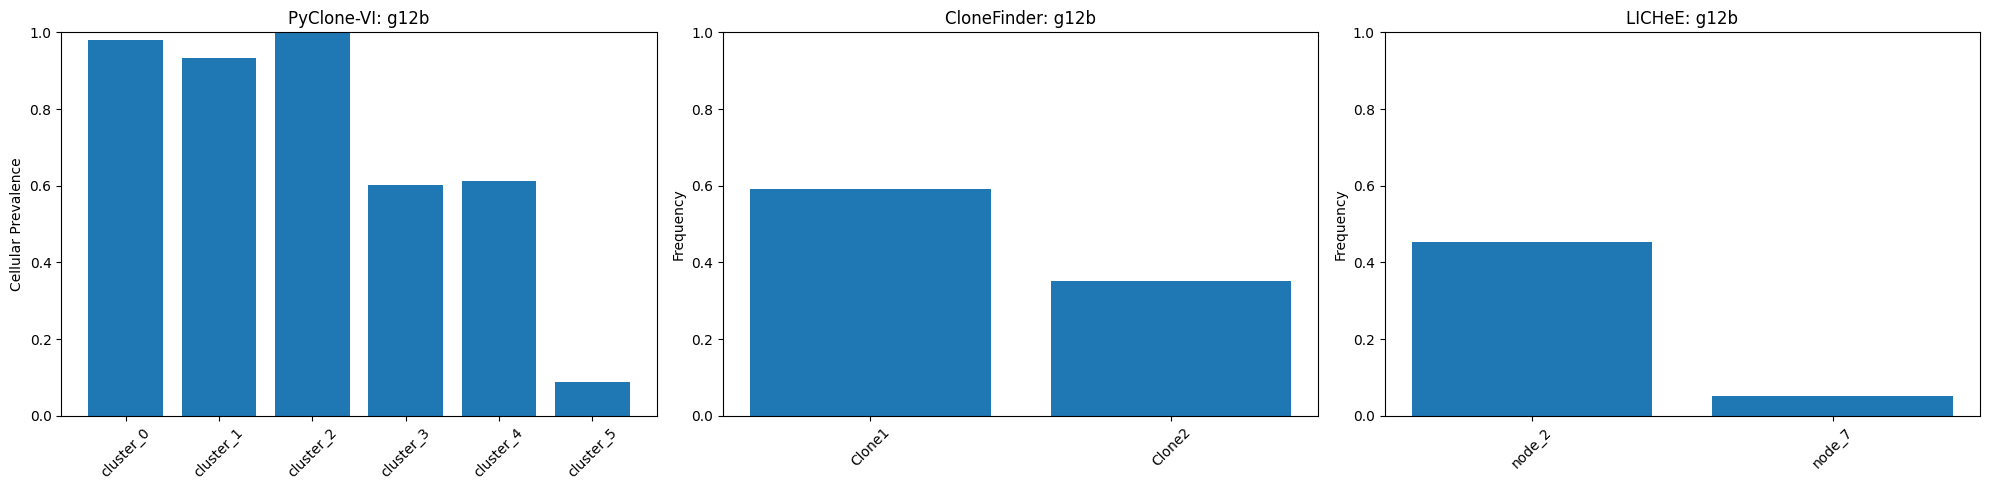

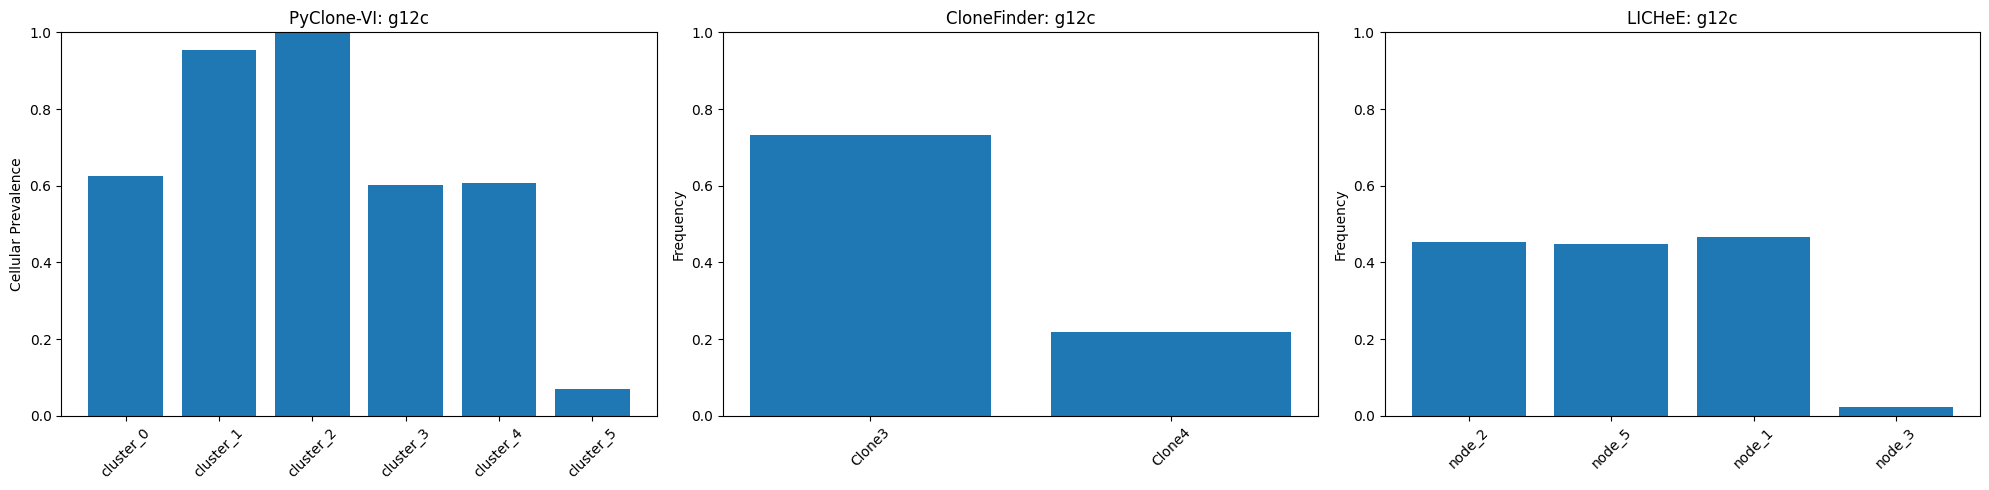

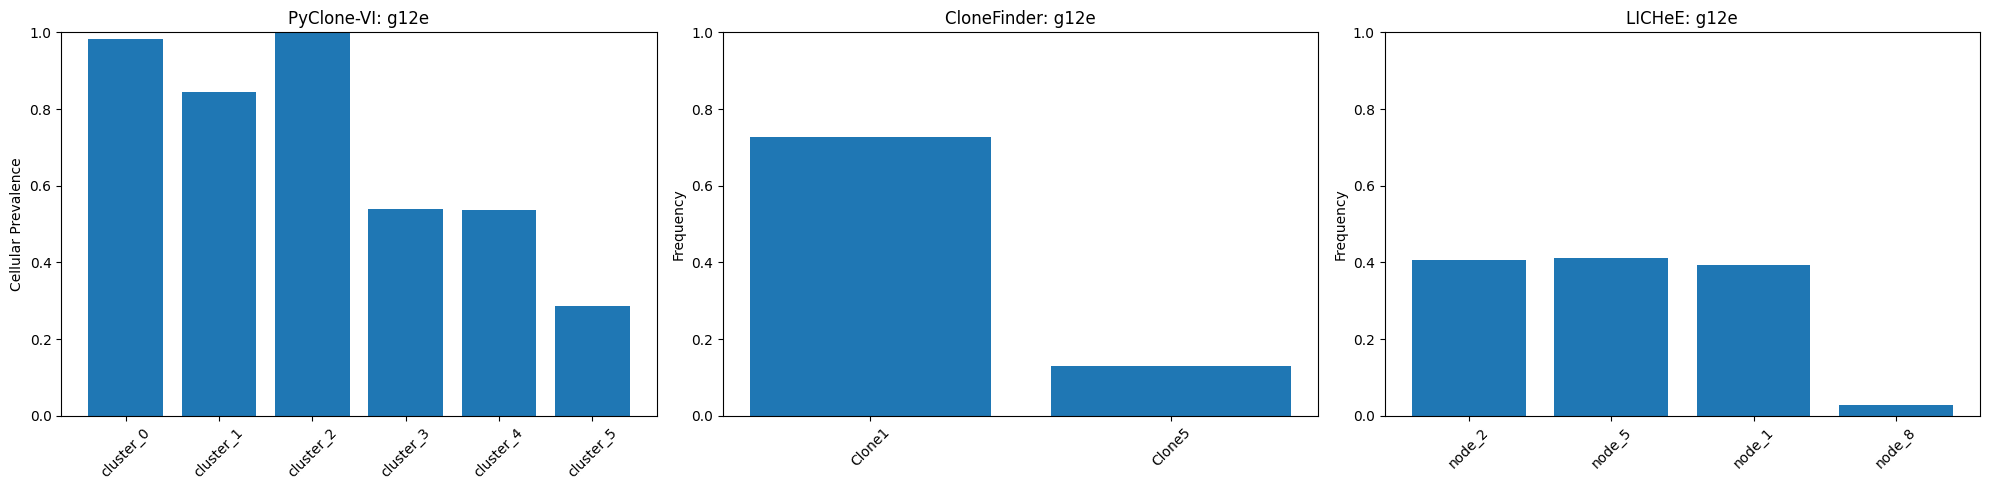

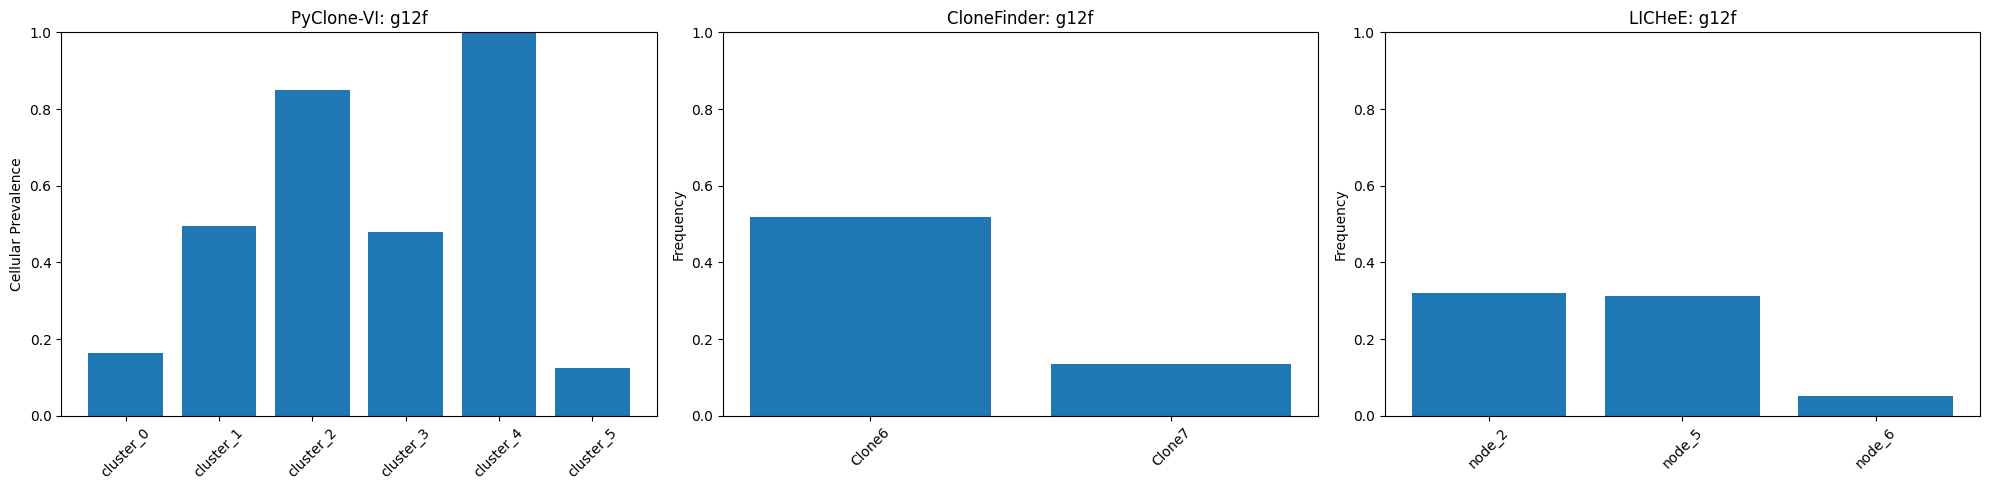

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# 1. Initialize the comparison tool
pyclone_file = "pyclone_results.tsv"
clonefinder_file = "clonefinder_inputsnv_CloneFinder.txt"
lichee_file = "lichee_input.txt.trees.txt"

# Create the tool instance
comparer = ClonalComparisonTool(
    pyclone_file=pyclone_file, 
    clonefinder_file=clonefinder_file, 
    lichee_file=lichee_file
)

# 2. Compare clone frequencies and counts
clone_comparison = comparer.compare_clones()

# Display clone counts in a DataFrame
clone_counts_df = comparer.create_clone_count_dataframe()
display(clone_counts_df)

# 3. Plot clone frequencies for each sample
clone_freq_plots = comparer.plot_clone_frequencies(figsize=(20, 5))
# for sample, fig in clone_freq_plots.items():
#     plt.figure(fig.number)
#     plt.savefig('sine_wave.png')
#     plt.tight_layout()
#     plt.show()

In [101]:
from IPython.display import display
from PIL import Image

display(HTML(f'<img src="lichee_tree_new.png" width="600" height="500">'))